In [106]:
import os
import re
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import util_functions as ut
import config as conf
import pickle
import pandas as pd
import geopandas as gpd
import math
from od_connector import od_cnx
from shapely import wkt, geometry
from supernetwork import Supernetwork
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#%% read pickled supernetwork (which includes unimodal networks joined by transfer edges)
cwd = os.getcwd()
G_super_od = od_cnx(os.path.join(cwd, 'Data', 'Output_Data', 'G_super.pkl'), 
                        conf.config_data['Supernetwork']['org'],[-79.945482, 40.420469])

<AxesSubplot:>

<AxesSubplot:>

,index,pos,nwk_type,node_type,Station Name,# of Racks,Latitude,Longitude,geometry,zone,...,longitude,float_rate,stop_name,route_id,direction_id,stop_id,stop_sequence,x,y,nwk_name
0,bs0,"(-79.91422624760675, 40.42690024412817)",bs,bs,NaN,NaN,NaN,NaN,POINT (-79.91423 40.42690),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-79.914226,40.426900,NaN
1,bs1,"(-79.9497447003733, 40.43444259643129)",bs,bs,NaN,NaN,NaN,NaN,POINT (-79.94974 40.43444),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-79.949745,40.434443,NaN
2,bs2,"(-79.94241028344199, 40.41576232100757)",bs,bs,NaN,NaN,NaN,NaN,POINT (-79.94241 40.41576),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-79.942410,40.415762,NaN
3,bs3,"(-79.93749991958343, 40.432736188582965)",bs,bs,NaN,NaN,NaN,NaN,POINT (-79.93750 40.43274),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-79.937500,40.432736,NaN
4,bs4,"(-79.93615858988125, 40.43985819780361)",bs,bs,NaN,NaN,NaN,NaN,POINT (-79.93616 40.43986),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-79.936159,40.439858,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8036,tw216,"(-79.93178300536127, 40.44915345427908)",NaN,tw,NaN,NaN,NaN,NaN,POINT (-79.93178 40.44915),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-79.931783,40.449153,t
8037,tw937,"(-79.9255076896622, 40.45131091524447)",NaN,tw,NaN,NaN,NaN,NaN,POINT (-79.92551 40.45131),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-79.925508,40.451311,t
8038,tw508,"(-79.92843663059188, 40.45021164768596)",NaN,tw,NaN,NaN,NaN,NaN,POINT (-79.92844 40.45021),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-79.928437,40.450212,t
8039,org,"(-79.94868171046522, 40.416379503934145)",od,od,NaN,NaN,NaN,NaN,POINT (-79.94868 40.41638),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-79.948682,40.416380,NaN


c:\Users\lgraff\anaconda3\envs\mm\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\lgraff\anaconda3\envs\mm\lib\site-packages\pandas\core\dtypes\cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


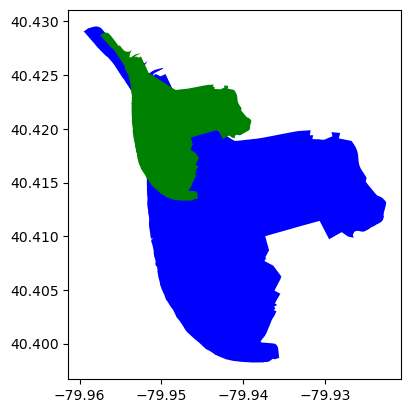

In [107]:
#%%
# choose only a single neighborhood to use for visualization
cwd = os.getcwd()
path = os.path.join(cwd, 'Data', 'Input_Data', 'Neighborhoods', "Neighborhoods_.shp")
nhoods = gpd.read_file(path)  # all neighborhoods
hood = conf.config_data['Geography']['neighborhoods'][0]  # only the ith neighborhood in the list
hood_gdf = nhoods[nhoods['hood'] == hood]  

# one neighbrhood is still too big to visualize. let's scale down by 50%
fig,ax = plt.subplots()
scale_factor = 0.5
x=0.5
y=0.5
scaled_gdf = hood_gdf.geometry.scale(xfact=scale_factor, yfact=scale_factor).translate(-1/69*x, 1/69*y)
hood_gdf.plot(ax=ax, color='blue')
scaled_gdf.plot(ax=ax, color='green')
                           

df = pd.DataFrame.from_dict(dict(G_super_od.graph.nodes), orient="index").reset_index()
#gdf_pt = gpd.GeoDataFrame(data=df, geometry=df.pos)
df[['x','y']] = pd.DataFrame(df.pos.tolist())
gdf_nodes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x,df.y))
gdf_nodes.set_crs(epsg='4326', inplace=True)
nodes_clip = gpd.clip(gdf_nodes, scaled_gdf)
nodes_clip.set_index('index', inplace=True)

# go back to the original PT graph, only keep nodes edges that are within the selected neighborhood
# 1) Nodes
G = nx.DiGraph()
node_dict = nodes_clip.to_dict(orient='index')
G.add_nodes_from(node_dict.keys())
nx.set_node_attributes(G, node_dict)
# 2) Edges
df_edges = nx.to_pandas_edgelist(G_super_od.graph)
df_edges_keep = df_edges.loc[(df_edges['source'].isin(list(G.nodes))) & (df_edges['target'].isin(list(G.nodes)))]
df_edges_keep.set_index(['source','target'], inplace=True)
edge_dict = df_edges_keep.to_dict(orient='index')
G.add_edges_from(edge_dict.keys())
nx.set_edge_attributes(G, edge_dict)


In [114]:
#%% **for visualization**: jitter the graphs and draw
def jitter_nodes(G, network_type, jitter_param):
    #G_adj = G.copy()
    #print(G.nodes) #[node]['pos'])
    # adjust the nodes positions in the copy 

    # TODO: go back to original code that builds t-wait nodes. for the node attribute, change 'nwk_name' to 'nwd_type'
    nodes = [n for n in G.nodes.keys() if n not in ['org','dst'] if (G.nodes[n]['nwk_type'] == network_type or G.nodes[n]['nwk_name'] == network_type) ]
    for n in nodes:
        adj_x = G.nodes[n]['pos'][0] + jitter_param
        adj_y = G.nodes[n]['pos'][1] + jitter_param
        nx.set_node_attributes(G, {n: {'pos_adj':(adj_x, adj_y)}})

modes_included = conf.config_data['Supernetwork']['modes_included']
modes_included.remove('pt')
modes_included.insert(math.floor(len(modes_included)/2), 'pt')  # explicitly have PT graph be the one in the center

jitter_param_dict = {m: (j/200)*2 for j,m in enumerate(modes_included)}  # can adjust jitter param as necessary
jitter_param_dict['tw'] = jitter_param_dict['t']  # also include the tnc waiting nodes
# explicitly adjust org and dest if they are in the node list
if 'org' in list(G.nodes):
    G.nodes['org']['pos_adj'] = (G.nodes['org']['pos'][0], G.nodes['org']['pos'][1] + jitter_param_dict['sc']) 
if 'dst' in list(G.nodes):
    G.nodes['dst']['pos_adj'] = (G.nodes['dst']['pos'][0], G.nodes['dst']['pos'][1] + jitter_param_dict['sc']) 

for m in modes_included: #+ ['tw']:
    jitter_nodes(G, m, jitter_param_dict[m])

In [115]:
for n in G.nodes:
    if n.startswith('bsd'):
        print(n)

bsd1085


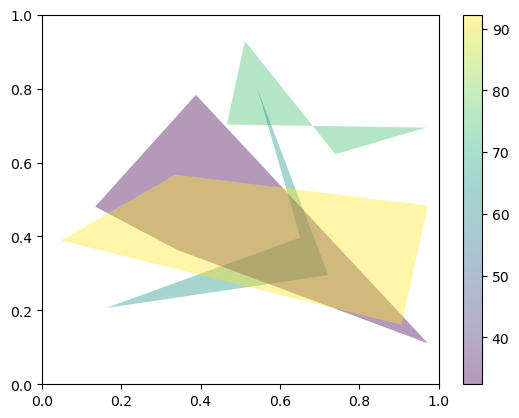

In [122]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# Fixing random state for reproducibility
np.random.seed(19680801)

fig, ax = plt.subplots()

resolution = 50  # the number of vertices
N = 4
x = np.random.rand(N)
y = np.random.rand(N)
radii = 0.1*np.random.rand(N)
patches = []

for i in range(N):
    polygon = Polygon(np.random.rand(N, 2), closed=True)
    patches.append(polygon)

colors = 100 * np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.4)
p.set_array(colors)
ax.add_collection(p)
fig.colorbar(p, ax=ax)

plt.show()

In [116]:
# draw the graph in networkx
node_color_map = {'bs':'green', 'bsd':'lime', 'z':'blue', 'zd': 'skyblue', 'kz': 'dodgerblue',
                  'sc':'darkviolet', 't':'red', 'tw':'red', 'ps':'brown', 'rt': 'orange' , 'od':'black'}
node_color = [node_color_map[G.nodes[n]['node_type']] for n in G.nodes.keys()]
edges_remove = [e for e in G.edges if e[0].startswith('tw')]
edges_keep = list(set(list(G.edges)) - set(edges_remove))  # remove the edges that go from t-wait to t
edge_color = ['darkgray' if G.edges[e]['mode_type'] == 'w' else 'black' for e in edges_keep] 
edge_style = [(0,(5,10)) if G.edges[e]['mode_type'] == 'w' 
               else 'dotted' if G.edges[e]['mode_type'] in ['board','alight'] else 'solid' for e in edges_keep] 

pos = 'pos_adj'
node_coords = nx.get_node_attributes(G, pos)    

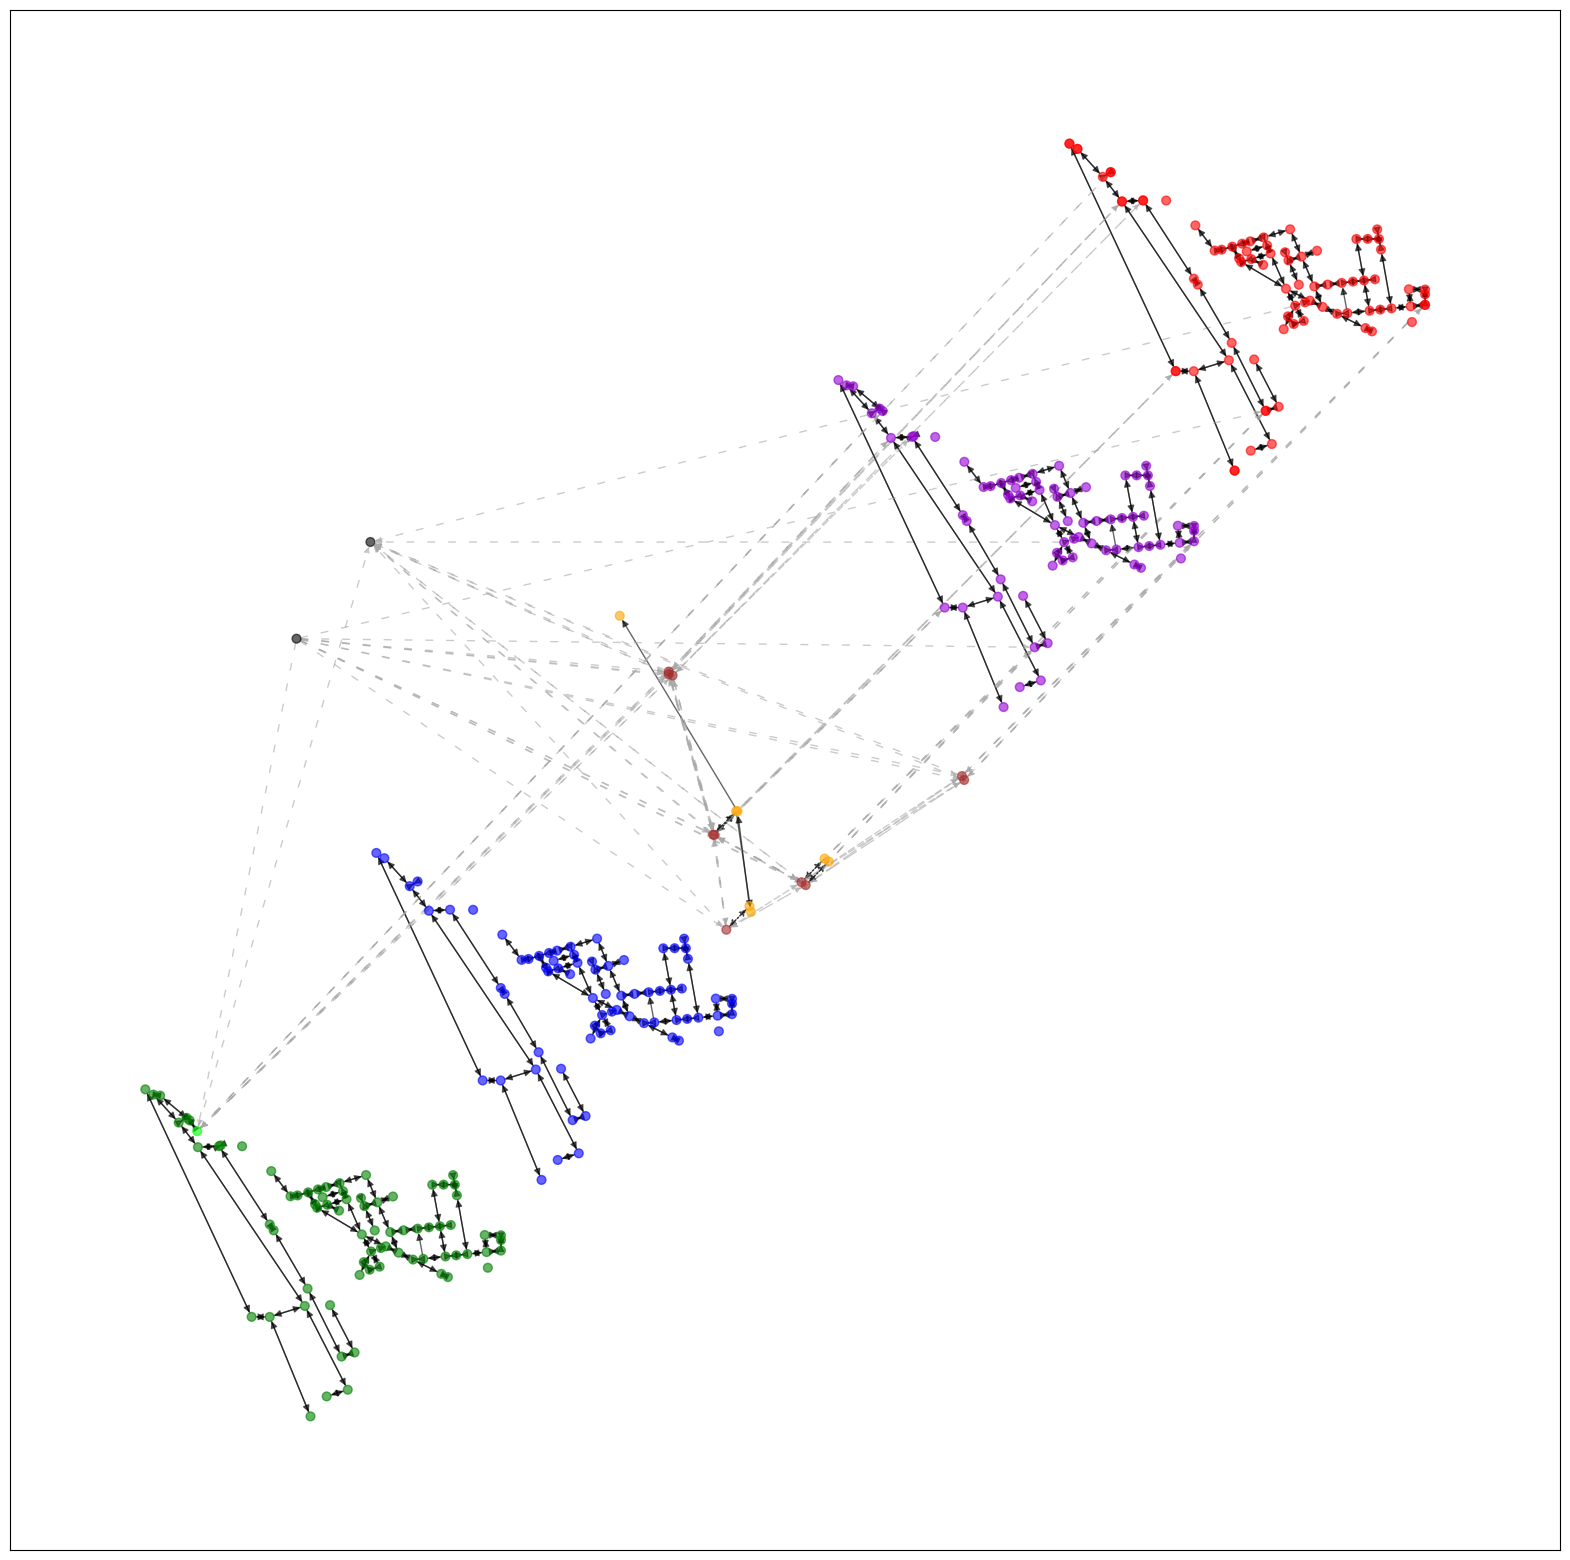

In [117]:
fig, ax = plt.subplots(figsize=(20,20))
nx.draw_networkx(G, pos=node_coords, node_color=node_color, node_size=40, alpha=0.6, edgelist=edges_keep, edge_color=edge_color, 
                style=edge_style, with_labels=False, ax=ax)

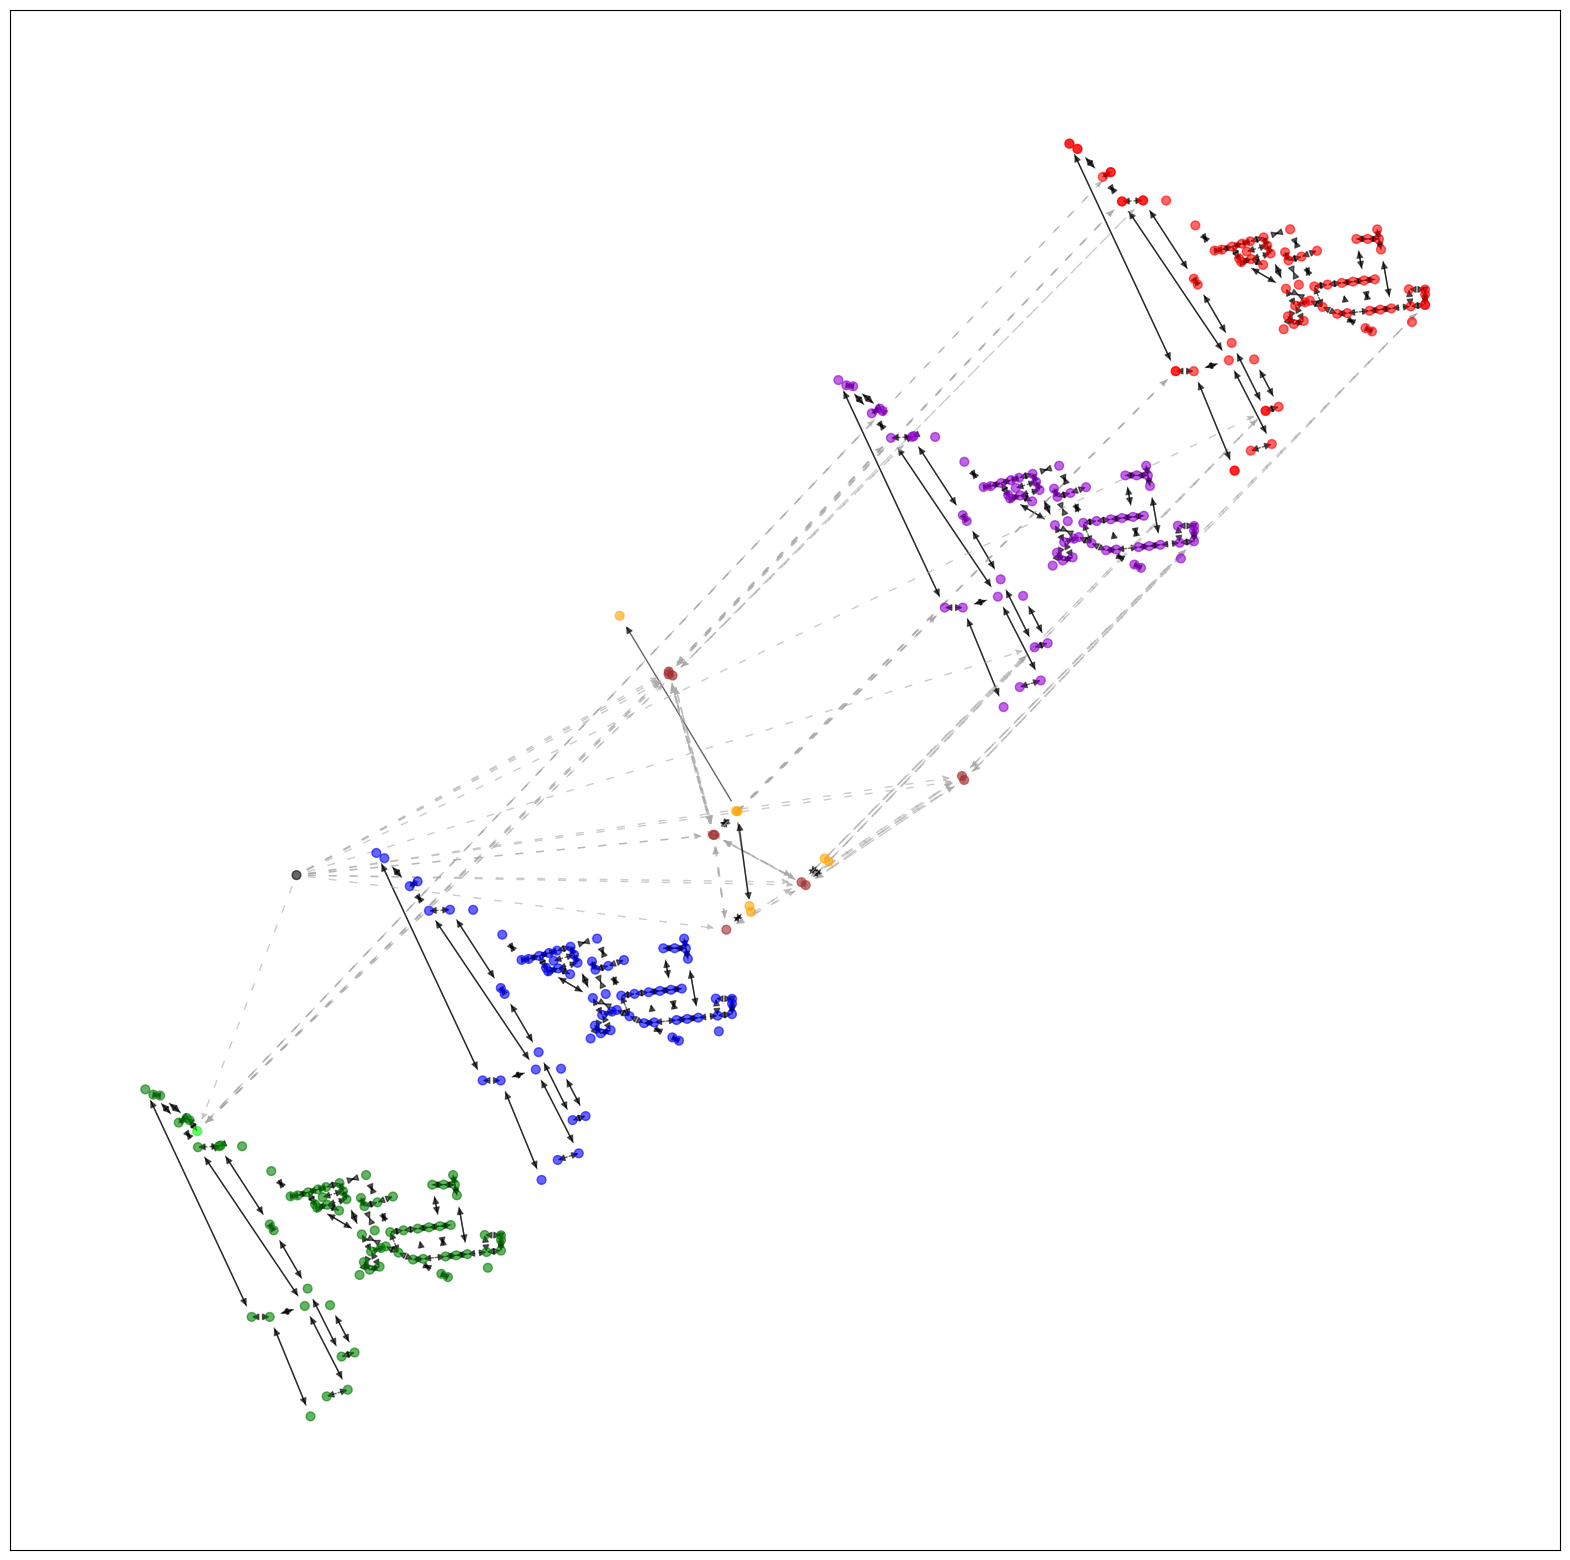

In [100]:
fig, ax = plt.subplots(figsize=(20,20))
nx.draw_networkx_nodes(G, pos=node_coords, node_color=node_color, node_size=40, alpha=0.6, ax=ax)
nx.draw_networkx_edges(G, pos=node_coords, edgelist=edges_keep, edge_color=edge_color, style=edge_style, alpha=0.6, arrowsize=10, ax=ax)